# The preceeding ipynb is semi more general in selecting it's blurring region.
# It is capable of selecting cuboid, i.e. unequal sides
# This ipynb restricts to only cubes, i.e. equal sides, as an attempt to be more computationally efficient
# The reason for this restriction relies on the assumption that the blurring region are spheres

## Importing Libraries

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import py21cmfast as p21c
# import caffeine
from datetime import datetime
import time
import logging, sys, os

## Daily Python Zen

In [3]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


## Set logger to log caching activity

In [4]:
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

## Version of 21cmFAST

In [5]:
print(f"Using 21cmFAST version {p21c.__version__}")

Using 21cmFAST version 3.0.0.dev5


## Number of cores running

In [6]:
print(f'Number of threads running = {os.cpu_count()}')

Number of threads running = 16


## Reset cache location 

In [7]:
p21c.config['direc'] = '/lustre/aoc/projects/hera/wchin/21cmFAST-cache'

## Gaussian function

In [8]:
def Gaussian(x, sigma):  # μ=0, σ=1/sqrt(2), π=1
    Gaussian = np.exp(-(x/sigma)**2)
    return Gaussian

## Measure the distance of each voxel to the center

In [9]:
def distance_from_coordinate(box_length):
        
    index = np.arange(-0.5*(box_length-1), 0.5*(box_length+1))

    x_mesh, y_mesh, z_mesh = np.meshgrid(index, index, index, indexing='ij')
    
    distance = np.sqrt((x_mesh)**2 + (y_mesh)**2 + (z_mesh)**2)
    
    return distance

## Random Coordinate

In [10]:
def random_voxel(box_length):
    
    np.random.seed()  # set seed to a randome number
#     np.random.seed(4) ; np.random.rand(10)  # specifying seed for testing purposes

    coordinate = np.random.randint(0, box_length, size=3)

    return coordinate

## Select a Smaller Cube with Sides 2R+1 Voxels, Centered about the Random Coordinate

In [11]:
def cube_centered_about_coordinate(coordinate_array, radius, box):
    x_ind1 = int(coordinate_array[0]-radius)  # x-domian
    x_ind2 = int(coordinate_array[0]+radius+1)  # ending index is not inclusive
    y_ind1 = int(coordinate_array[1]-radius)  # y-domain
    y_ind2 = int(coordinate_array[1]+radius+1)
    z_ind1 = int(coordinate_array[2]-radius)  # z-domain
    z_ind2 = int(coordinate_array[2]+radius+1)
        
    if x_ind1 < 0:  # periodic boundary conditions
        x_inds = np.r_[(x_ind1+len(box)):len(box), 0:x_ind2]
    elif x_ind2 > len(box):
        x_inds = np.r_[x_ind1:len(box), 0:(x_ind2-len(box))]
    else:
        x_inds = np.r_[x_ind1:x_ind2]

    if y_ind1 < 0:
        y_inds = np.r_[(y_ind1+len(box)):len(box), 0:y_ind2]
    elif y_ind2 > len(box):
        y_inds = np.r_[y_ind1:len(box), 0:(y_ind2-len(box))]
    else:
        y_inds = np.r_[y_ind1:y_ind2]

    if z_ind1 < 0:
        z_inds = np.r_[(z_ind1+len(box)):len(box), 0:z_ind2]
    elif z_ind2 > len(box):
        z_inds = np.r_[z_ind1:len(box), 0:(z_ind2-len(box))]
    else:
        z_inds = np.r_[z_ind1:z_ind2]
            
    indices = np.ix_(x_inds, y_inds, z_inds)
        
    try:
        output_box = box[indices]
        
    except IndexError:  # sample region larger than box.
        print(f'coordinate array = {coordinate_array}')
        print(f'radius = {radius}')
        print(f'box length = {len(box)}')
        print(f'x_ind1 = {x_ind1}')
        print(f'x_ind2 = {x_ind2}')
        print(f'x_inds = {x_inds}')
        print(f'x_ind1 = {y_ind1}')
        print(f'x_ind2 = {y_ind2}')
        print(f'y_inds = {y_inds}')
        print(f'x_ind1 = {z_ind1}')
        print(f'x_ind2 = {z_ind2}')
        print(f'z_inds = {z_inds}')
        
    return output_box

## Gausssian Sphere Averaging

In [58]:
def gaussian_sphere_average(distance_box, radius, input_box, shell_num, sigma_factor):
    
    mean = np.zeros(shell_num)

    shell_radius_edges = np.linspace(0,1,shell_num+1)
    # sigma_factor number of sigmas the weighting goes out to, sigma = radius

    
    
# ======================================================================================================================
    # Radius Ratio 1
    shell_center = 0.5*(shell_radius_edges[1:] + shell_radius_edges[:-1])*sigma_factor 
    weight = Gaussian(x=shell_center, sigma=1)
    
    # Radius Ratio 2
#     shell_center = 0.5*(shell_radius_edges[1:] + shell_radius_edges[:-1])*sigma_factor*radius
#     weight = Gaussian(x=shell_center, sigma=radius)
# ======================================================================================================================


    
    for ii in range(shell_num):
        condition = np.logical_and(
            distance_box <= shell_radius_edges[ii+1]*radius, 
            distance_box > shell_radius_edges[ii]*radius
        )
        inside_shell_mean = np.mean(input_box[condition])
        mean[ii] = inside_shell_mean
        
    Gaussian_mean = np.average(mean, weights=weight)
    
    return Gaussian_mean

## Top Hat Sphere Averaging

In [13]:
def top_hat_sphere_average(distance_box, radius, input_box):
    
    condition = distance_box <= radius
    mean = np.mean(input_box[condition])
    
    return mean

## Top Hat Cube Averaging

In [14]:
def top_hat_cube_average(input_box):
    
    mean = np.mean(input_box)
    
    return mean

## Sphere Blurring Function

In [15]:
def Average_Neutral_Fraction_Distribution(
    box, 
    radius, 
    iteration, 
    shell_num=6, 
    sigma_factor=4, 
    blur_shape=None
):
    
    box = box.copy()  # make copy of input box to have a separate box
    
    mean_data = []  # empty list for data collection
    
    if blur_shape == 'Gaussian_sphere':
        
        
# ======================================================================================================================
        # Radius Ratio 1
        radius = int(round(radius*1.4370397097748921*3))
        
        # Radius Ratio 2
#         radius = int(round(radius*((4/3/np.sqrt(np.pi))**(1/3))*13/4))  # 13/4 --> speculated correction factor
# ======================================================================================================================
        
        
        # check to see if averaging region is largert than the box itself
        if radius > (len(box)-1)/2:
            print(f'Radius = {radius} > {(len(box)-1)/2} = (Box Length-1)/2, averaging region is larger than the box itself.')
            print('Code terminated.')
            sys.exit()
            
        dist_frm_coord_box = distance_from_coordinate(radius*2+1)
        for i in range(iteration):
            rand_coord = random_voxel(len(box))
            cube_region_box = cube_centered_about_coordinate(rand_coord, radius, box)
            mean = gaussian_sphere_average(dist_frm_coord_box, radius, cube_region_box, shell_num, sigma_factor)
            mean_data = np.append(mean_data, mean)
        
    elif blur_shape == 'top_hat_sphere':
        
        # check to see if averaging region is largert than the box itself
        if radius > (len(box)-1)/2:
            print(f'Radius = {radius} > {(len(box)-1)/2} = (Box Length-1)/2, averaging region is larger than the box itself.')
            print('Code terminated.')
            sys.exit()

        dist_frm_coord_box = distance_from_coordinate(radius*2+1)
        
        for i in range(iteration):
            rand_coord = random_voxel(len(box))
            cube_region_box = cube_centered_about_coordinate(rand_coord, radius, box)
            mean = top_hat_sphere_average(dist_frm_coord_box, radius, cube_region_box)
            mean_data = np.append(mean_data, mean)
            
    elif blur_shape == 'top_hat_cube':
                
        radius = int(round((radius*((4*np.pi/3)**(1/3))-1)/2))  # ratio determiend by equating the volumes of cube & sphere

        # check to see if averaging region is largert than the box itself
        if radius > (len(box)-1)/2:
            print(f'Radius = {radius} > {(len(box)-1)/2} = (Box Length-1)/2, averaging region is larger than the box itself.')
            print('Code terminated.')
            sys.exit()
        
        for i in range(iteration):
            rand_coord = random_voxel(len(box))
            cube_region_box = cube_centered_about_coordinate(rand_coord, radius, box)
            mean = top_hat_cube_average(cube_region_box)
            mean_data = np.append(mean_data, mean)
    else:
        print('Blurring shape assumed to be a Gaussian sphere with 4 shells \
              weighted by equally spaced values from 0 sigma to 4 sigma.')
                
        
# ======================================================================================================================
        # Radius Ratio 1
        radius = int(round(radius*1.4370397097748921*3))
        
        # Radius Ratio 2
#         radius = int(round(radius*((4/3/np.sqrt(np.pi))**(1/3))*13/4))  # 13/4 --> speculated correction factor
# ======================================================================================================================
        
        
        # check to see if averaging region is largert than the box itself
        if radius > (len(box)-1)/2:
            print(f'Radius = {radius} > {(len(box)-1)/2} = (Box Length-1)/2, averaging region is larger than the box itself.')
            print('Code terminated.')
            sys.exit()
        
        dist_frm_coord_box = distance_from_coordinate(radius*2+1)
        
        for i in range(iteration):
            rand_coord = random_voxel(len(box))
            cube_region_box = cube_centered_about_coordinate(rand_coord, radius, box)
            mean = gaussian_sphere_average(dist_frm_coord_box, radius, cube_region_box, shell_num, sigma_factor)
            mean_data = np.append(mean_data, mean)
            
    return mean_data

## Histogram Function

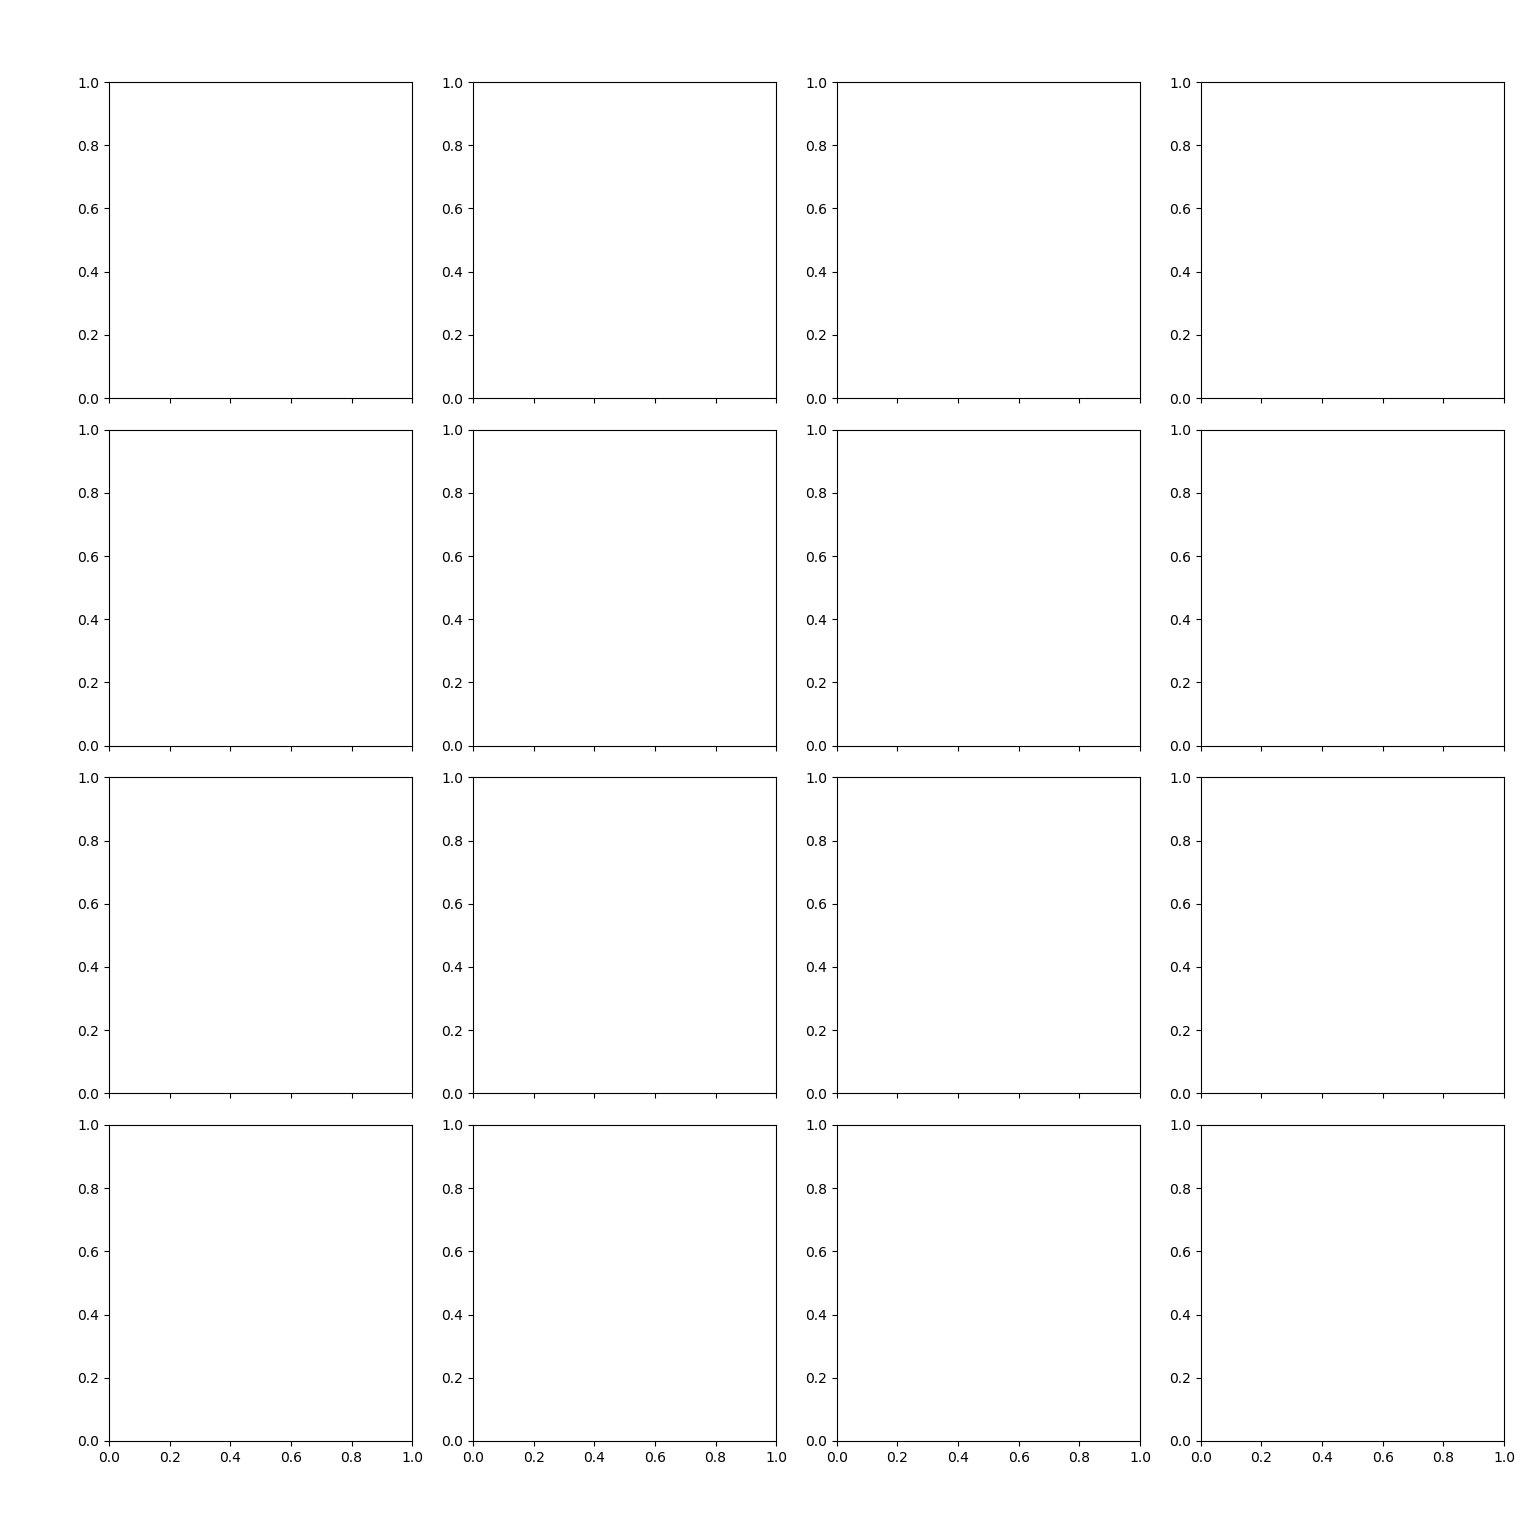

In [30]:
def histogram(
    y1s, 
    figure_shape, 
    y2s=None,
    y3s=None,
    marker_lines=None,
    y1s_label=None,
    y2s_label=None,
    y3s_label=None,
    title=None, 
    shared_title=None,
    shared_title_x_position=0.5,   # figure coordinates, max=1 I think
    shared_title_y_position=0.92,
    shared_x_label=None, 
    shared_x_label_x_position=0.5,
    shared_x_label_y_position=0.08,
    shared_y_label=None, 
    shared_y_label_x_position=0.07,
    shared_y_label_y_postion=0.5,
    x_start=0, 
    x_stop=1, 
    bin_num=100, 
    color='white', 
    figure_size=(18,7), 
    font_size=15, 
    horizontal_gap=0.05, 
    vertical_gap=0.05, 
    y_scale='linear', 
    y_notation='plain', 
    share_x_axis=True, 
    share_y_axis=True,
    dpi=100
):  # a: x start, b: x stop
    
    bin_edges = np.linspace(x_start, x_stop, bin_num) # 100 bins from 0-1
    
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    if np.array(y1s).ndim > 2:  # hopefully more robust condition.
        
        fig, axes = plt.subplots(
            figure_shape[0], 
            figure_shape[1], 
            figsize=figure_size, 
            sharex=share_x_axis, 
            sharey=share_y_axis, 
            gridspec_kw={"hspace":vertical_gap, 'wspace':horizontal_gap},
            dpi=dpi
        )
        
        if shared_title != None:
            
            fig.suptitle(
                x=shared_title_x_position, 
                y=shared_title_y_position, 
                t=shared_title, ha='center', 
                size=1.5*font_size, 
                color=color
            )
            
        if shared_x_label != None:  # shared x label
            fig.text(
                x=shared_x_label_x_position, 
                y=shared_x_label_y_position, 
                s=shared_x_label, ha='center', 
                size=font_size, 
                color=color
            )

        if shared_y_label != None:  # shared y label
            fig.text(
                x=shared_y_label_x_position, 
                y=shared_y_label_y_postion, 
                s=shared_y_label, 
                va='center', 
                rotation='vertical', 
                size=font_size, 
                color=color
            )
        
        for i, y1 in enumerate(y1s):
            
            for ii, z in enumerate(redshifts):
                axes.flatten()[i].plot(
                    bin_centers, 
                    np.histogram(y1s[i,ii,:], bins=bin_edges)[0], 
                    marker_lines[ii], 
                    label=f'z={z}'
                )
            
            if iterable(y2s):
                axes.flatten()[i].plot(
                    bin_centers, 
                    np.histogram(y2s[i], bins=bin_edges)[0], 
                    '--', 
                    label=y2s_label
                )
                
                if iterable(y3s):
                    
                    axes.flatten()[i].plot(
                        bin_centers, 
                        np.histogram(y3, bins=bin_edges)[0], 
                        label=y3s_label
                    )
                    axes.flatten()[i].legend()
                    
                else:
                    axes.flatten()[i].legend()
                    
            else:
                axes.flatten()[i].legend()
                
                
            if title != None:
                axes.flatten()[i].set_title(title[i], color=color, fontsize=font_size)
                
            axes.flatten()[i].set_yscale(y_scale)
            
            if y_notation == 'sci':
                axes.flatten()[i].ticklabel_format(
                    axis='y', 
                    style=y_notation, 
                    scilimits=(0,0), 
                    useMathText=True
                )
                
            axes.flatten()[i].tick_params(
                color=color, 
                labelcolor=color, 
                labelsize=font_size, 
                size=font_size
            )  # font style

            for spine in axes.flatten()[i].spines.values():  # figure color
                spine.set_edgecolor(color)
                
    else:
        
        fig, ax = plt.subplots(figsize=figure_size)
        
        ax.plot(bin_centers, np.histogram(y1s, bins=bin_edges)[0], label=y1s_label)
        
        if y2s != None:
            ax.plot(bin_centers, np.histogram(y2s, bins=bin_edges)[0], '--', label=y2s_label)
            
            if y3s == None:
                ax.legend()
                
            else:
                ax.plot(bin_centers, np.histogram(y3s, bins=bin_edges)[0], '-.', label=y3s_label)
                ax.legend()
                
        if title != None:
            ax.set_title(title, color=color, fontsize=font_size)
            
        ax.set_yscale(y_scale)
        
        if y_notation == 'sci':
            ax.ticklabel_format(axis='y', style=y_notation, scilimits=(0,0), useMathText=True)
            
        ax.tick_params(color=color, labelcolor=color, labelsize=font_size)  # font style

        for spine in ax.spines.values():  # figure color
            spine.set_edgecolor(color)
            
#     plt.show()

## Check if object is iterable

In [17]:
def iterable(obj):
    
    try:
        iter(obj)
        
    except Exception:
        return False
    
    else:
        return True

## Cosmological Parameters (Default is used when no input is specified)

In [18]:
cosmo_params = p21c.CosmoParams()

## User Parameters, like box length, number of voxels (i.e. resolution) etc.

In [19]:
BOX_LEN=301  # 300, 301
HII_DIM=301  # 450, 301

user_params = p21c.UserParams(
    BOX_LEN=BOX_LEN,  # Box length in Mpc
    DIM=4*HII_DIM,      # Number of Voxels for hight resolution 
    HII_DIM=HII_DIM,  # Number of Voxels for low resolution 
    N_THREADS=os.cpu_count()
)

## Creating initial conditions box

In [20]:
start_time = datetime.now()
print(f'Excution qued at {start_time}')

init_cond = p21c.initial_conditions(
    cosmo_params=cosmo_params,
    user_params=user_params,
)

end_time = datetime.now()
execution_time = end_time - start_time
print(f'Execution completed at {end_time}')
print(f'Execution time = {execution_time}')

Excution qued at 2020-07-24 22:30:08.266748


2020-07-24 22:32:08,439 | INFO | Existing init_boxes found and read in (seed=230806296593).


Execution completed at 2020-07-24 22:32:08.440897
Execution time = 0:02:00.174149


## Generate ionized boxes as a function of redshift

In [25]:
redshifts = np.arange(8, 4.5, -0.5)
ionized_boxes = np.zeros((len(redshifts), HII_DIM, HII_DIM, HII_DIM))

for i, z in enumerate(redshifts):
    ionized_box = p21c.ionize_box(redshift=z, init_boxes=init_cond).xH_box
    ionized_boxes[i] = ionized_box

2020-07-24 22:35:35,000 | INFO | Existing z=8.0 ionized boxes found and read in (seed=230806296593).
2020-07-24 22:35:35,501 | INFO | Existing z=7.5 ionized boxes found and read in (seed=230806296593).
2020-07-24 22:35:35,992 | INFO | Existing z=7.0 ionized boxes found and read in (seed=230806296593).
2020-07-24 22:35:36,483 | INFO | Existing z=6.5 ionized boxes found and read in (seed=230806296593).
2020-07-24 22:35:36,972 | INFO | Existing z=6.0 ionized boxes found and read in (seed=230806296593).
2020-07-24 22:35:37,463 | INFO | Existing z=5.5 ionized boxes found and read in (seed=230806296593).
2020-07-24 22:35:37,951 | INFO | Existing z=5.0 ionized boxes found and read in (seed=230806296593).


## Generate Average Neutral Fraction Distributions as a function of redshift

In [26]:
def generate_distributions(
    boxes=ionized_boxes,
    radii=np.arange(8, 17, 1),
    iterations=10**2,
    sigma_factor=4,
    shell_number=6
):

    gaussians = []
    
    start_time = datetime.now()
    current_time = start_time
    print(f'Progress = 0%, localtime = {start_time}')

    for i, radius in enumerate(radii):
        
        for box in boxes:
                        
            gaussian = Average_Neutral_Fraction_Distribution(
                box=box,
                radius=radius,
                iteration=iterations,
                sigma_factor=sigma_factor,
                shell_num=shell_number,
                blur_shape='Gaussian_sphere'
            )

            gaussians = np.append(gaussians, gaussian)


        # print progress and local time
        previous_time = current_time
        current_time = datetime.now()
        loop_time = current_time - previous_time
        elapsed_time = current_time - start_time
        print(f'progress = {int(round((i+1)*100/len(radii)))}%, localtime =\
 {current_time}, loopexecuted in {loop_time}, elapsedtime = {elapsed_time}')

    gaussians = gaussians.reshape(len(radii), len(redshifts), iterations)
    
    return gaussians

## Generate the distributions and storing the data in global variables

In [59]:
radii = np.arange(34, 3, -2)  # array([34, 32, 30,... 6, 4]) units: voxels (51, 3, -3)
iterations = int(10**0)

gaussians2 = generate_distributions(
    boxes=ionized_boxes,
    radii=radii,
    iterations=iterations
)

Progress = 0%, localtime = 2020-07-24 22:47:02.487554
progress = 6%, localtime = 2020-07-24 22:47:10.149478, loopexecuted in 0:00:07.661924, elapsedtime = 0:00:07.661924
progress = 12%, localtime = 2020-07-24 22:47:16.541846, loopexecuted in 0:00:06.392368, elapsedtime = 0:00:14.054292
progress = 19%, localtime = 2020-07-24 22:47:21.899690, loopexecuted in 0:00:05.357844, elapsedtime = 0:00:19.412136
progress = 25%, localtime = 2020-07-24 22:47:26.333257, loopexecuted in 0:00:04.433567, elapsedtime = 0:00:23.845703
progress = 31%, localtime = 2020-07-24 22:47:29.957925, loopexecuted in 0:00:03.624668, elapsedtime = 0:00:27.470371
progress = 38%, localtime = 2020-07-24 22:47:32.888275, loopexecuted in 0:00:02.930350, elapsedtime = 0:00:30.400721
progress = 44%, localtime = 2020-07-24 22:47:35.298906, loopexecuted in 0:00:02.410631, elapsedtime = 0:00:32.811352
progress = 50%, localtime = 2020-07-24 22:47:37.239794, loopexecuted in 0:00:01.940888, elapsedtime = 0:00:34.752240
progress = 

## Creating Histogram

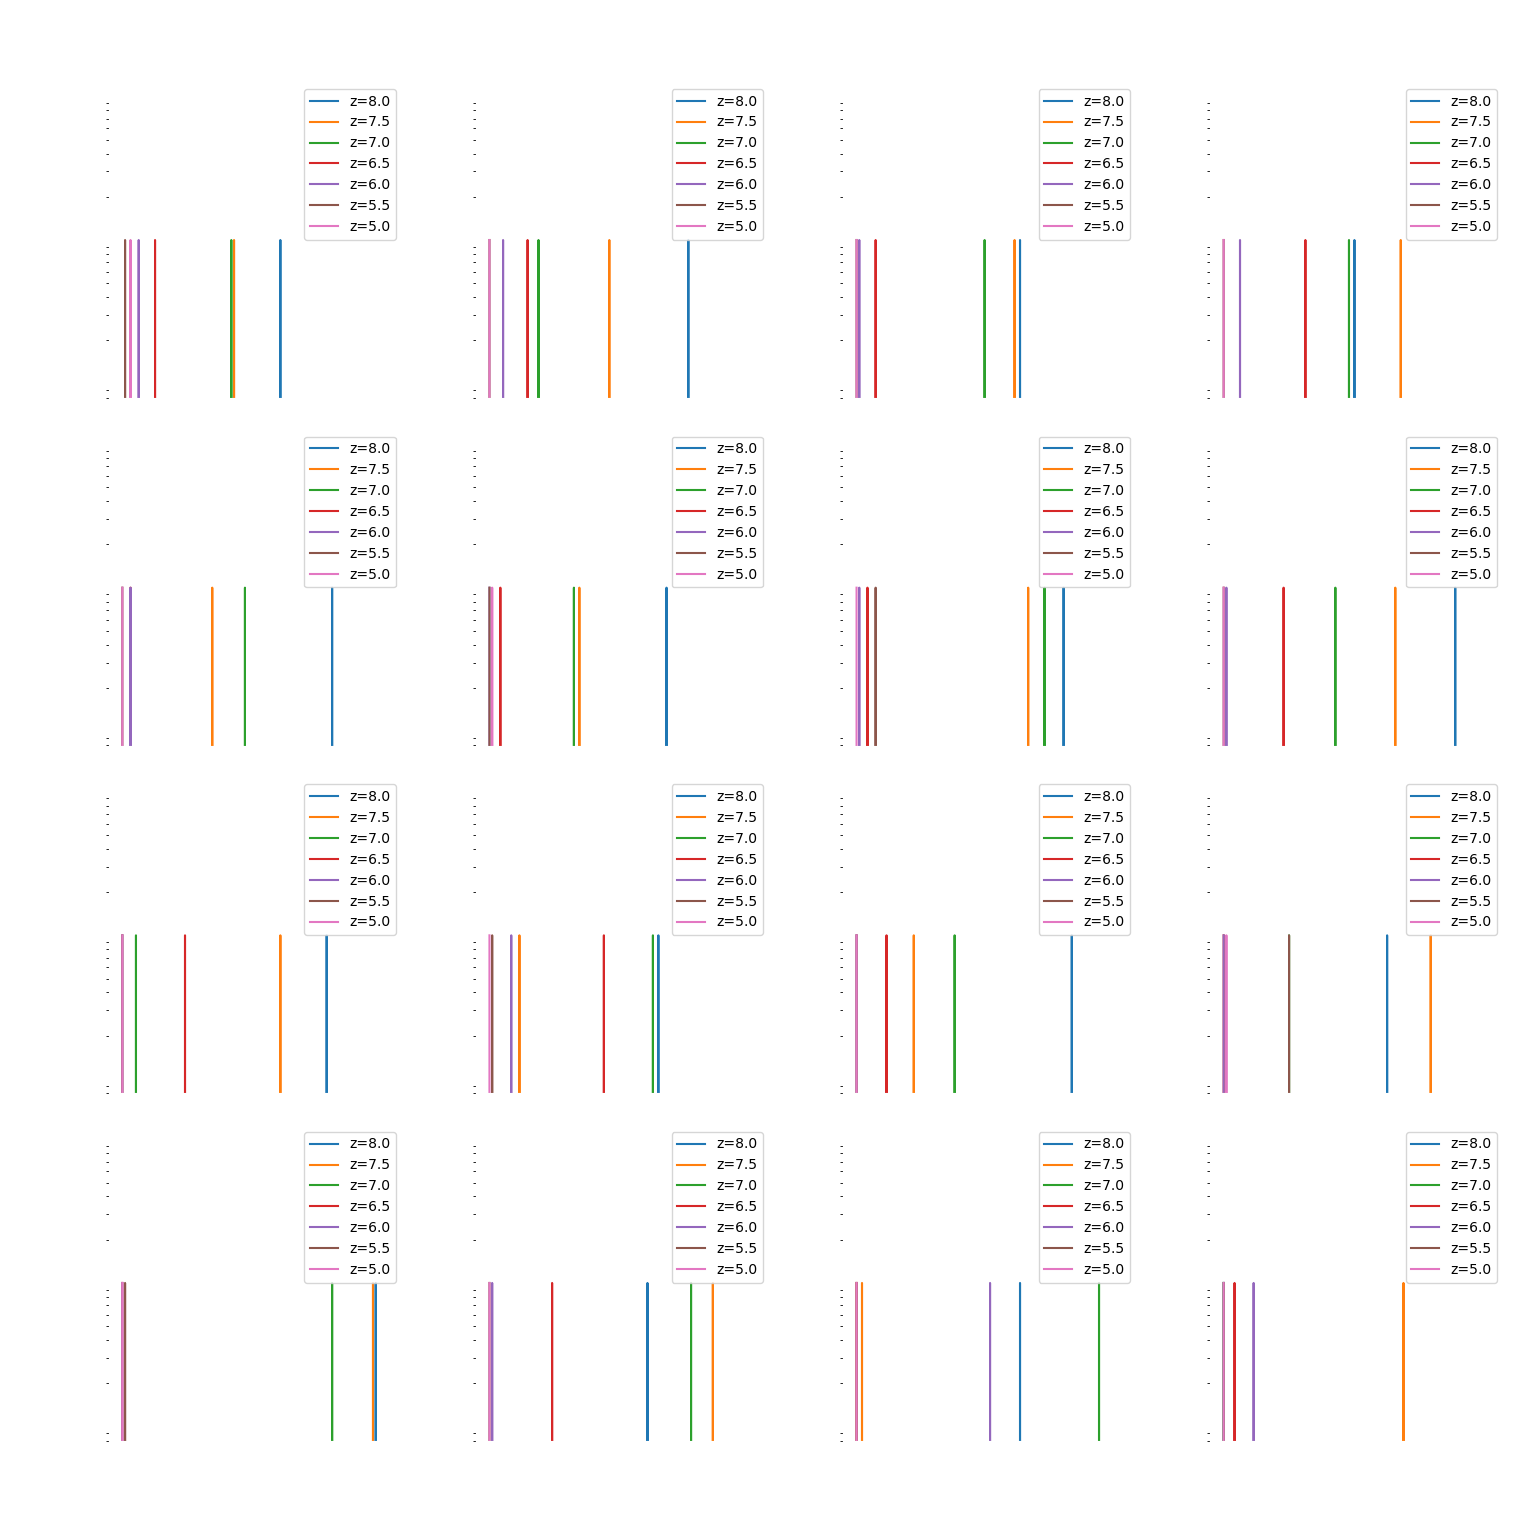

In [61]:
histogram(
    y1s=gaussians, 
    marker_lines=['-']*len(redshifts),
    title=[f'Radius={r*BOX_LEN/HII_DIM:.2f}Mpc' for r in radii],
    shared_title=f'Distribution of Average \
Neutral Fraction (RR1, iterations={iterations:.2e})',
    shared_y_label='Counts',
    shared_x_label='Neutral Fraction',
    figure_shape=(4,4), 
    figure_size=(18,18),
    vertical_gap=0.1,
    horizontal_gap=0.25,
    y_scale='log',
#     y_notation='sci',
    share_y_axis=False
#     dpi=1000
)